In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
import emcee

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

In [3]:
DATALC_PATH = "/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr/"
DATAMAIN_PATH= "/Users/mariavincenzi/PhD/pycoco_2/data/"

#OUTPUT
# - fitted_photometry
#  for each object (1) Table with fitted photometry @spctra MJD
#                  (2) high cadence fitted photometry 
#                  (3) plot of the fit in each band

mm_cob56 = 1./77.
mm_ni56 = 1./6.


In [4]:
info_objects = np.genfromtxt(DATAMAIN_PATH+'info/info.dat', dtype=None, names=True, encoding='utf-8')
name_type = dict(zip(info_objects['snname'], info_objects['Type']))

In [5]:
name_type.keys()

dict_keys(['SN2006T', 'SN2016X', 'SN2006bp', 'SN2002ap', 'SN2005bf', 'SN2009er', 'SN2010bq', 'SN2004aw', 'SN2013fs', 'SN2004gv', 'SN1996cb', 'SN2009ib', 'SN2009dd', 'SN2017eaw', 'SN2003bg', 'SN2009bb', 'SN2003jd', 'SN2008in', 'SN2008bj', 'SN2005cs', 'SN2009jf', 'SN2006aj', 'SN1998A', 'SN2009kr', 'SN2013ab', 'SN2004et', 'SN2004gt', 'SN2011hs', 'SN2013df', 'SN2006aa', 'SN1999dn', 'ASASSN15oz', 'SN2004gq', 'SN2009mg', 'SN2007pk', 'SN2009iz', 'SN2007ru', 'SN2004fe', 'SN2005db', 'SN1999em', 'SN2005hg', 'SN2008bo', 'SN2009N', 'SN2013hj', 'SN2007uy', 'iPTF13bvn', 'SN1994I', 'SN2009E', 'SN2007od', 'ASASSN15no', 'SN2011ei', 'SN2014G', 'SN2008D', 'SN2002gd', 'SN2004A', 'SN2012au', 'SN1998bw', 'SN2012ap', 'SN2011ht', 'SN2008fq', 'ASASSN14jb', 'SN2007C', 'SN2011bm', 'SN2013ge', 'SN2006el', 'SN2010al', 'SN1993J', 'SN1998S', 'SN2007Y', 'SN2016gkg', 'SN2000cb', 'SN2008aq', 'SN2009ip', 'SN2006ep', 'SN2005cp', 'SN2012aw', 'SN2011fe', 'SN2008ax', 'SN2006V', 'SN2007gr', 'SN2006jc', 'SN2012A', 'SN1999el',

In [6]:
color_dict = {'A':'grey',
              'BessellU': 'blue',
              'BessellB': 'royalblue',
                'BessellV':  'limegreen',
                'BessellR':  'red',
                'BessellI':  'mediumvioletred',
                'SDSS_g':    'darkgreen',
                'SDSS_i':    'purple',
                'SDSS_r':    'darkred',
                'SDSS_z':    'sienna',
                'SDSS_u': 'darkblue',
                'swift_UVW1':'grey',
                'swift_UVW2':'grey',
                'swift_UVM2':'grey',
                'swift_U':'grey',
                'swift_V':'grey',
                'swift_B':'grey'}

color_dict = {'A':'grey',
              'Bessell_U': 'blue',
              'Bessell_B': 'royalblue',
                'Bessell_V':  'limegreen',
                'Bessell_R':  'red',
                'Bessell_I':  'mediumvioletred',
                'sdss_g':    'darkgreen','ptf_g':    'darkgreen', "sdss_g'":    'darkgreen',
                'sdss_i':    'indianred', "sdss_i'":    'indianred',
                'sdss_r':    'darkred', "sdss_r'":    'darkred',
                'sdss_z':    'sienna', "sdss_z'":    'sienna',
                'sdss_u': 'darkblue', "sdss_u'": 'darkblue',
                'Y':  'salmon','H':  'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown',
                'swift_UVW1':'indigo',
                'swift_UVW2':'darkblue',
                'swift_UVM2':'darkmagenta',
                'swift_U':'plum',
                'swift_V':'teal',
                'swift_B':'powderblue'}

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']

In [7]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux

## linear regression from x,y independent errors
def lin_regr_weigthed(x,y,w):
    Delta = sum(w)*sum(w*x**2) - (sum(w*x))**2
    A = ( sum(w*x**2)*sum(w*y) - sum(w*x)*sum(w*y*x) )/(Delta)
    B = ( sum(w)*sum(w*y*x) - sum(w*x)*sum(w*y) )/(Delta)
    print (A,B)
    sigma_A = np.sqrt( sum(w*x**2)/Delta )
    sigma_B = np.sqrt( sum(w)/Delta )
    print (sigma_A,sigma_B)


    return (A,B,sigma_A,sigma_B)

In [8]:

class SNPhotometryClass():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, main_path, lc_path, snname, verbose=False):
        """
        """

        ## Initialise the class variables
        self.main_path = main_path
        self.lc_data_path = lc_path+'/'
        #self.lc_data_path = '/Users/mariavincenzi/PhD/pycoco_2/data/lc/'

        self.spec_data_path = main_path+'/spec/'
        self.snname = snname   
        self.set_data_directory(verbose)

    def set_data_directory(self, verbose):
        """
        Set a new data directory path.
        Enables the data directory to be changed by the user.
        """
        SNphotometry_PATH = os.path.join(self.lc_data_path, '%s.dat'%self.snname)
        
        try:
            if verbose: print('Looking for Photometry for %s in%s'%(self.snname, SNphotometry_PATH))
            if os.path.isfile(SNphotometry_PATH):
                if verbose: print ('Got it!')
                self.sn_rawphot_file = SNphotometry_PATH
                pass
            else:
                if not os.path.isdir(self.lc_data_path):
                    print ('I cant find the directory with photometry. Check %s'%self.lc_data_path)
                    pass
                else: 
                    print ('I cant find the file with photometry. Check %s'%SNphotometry_PATH)
                    pass
    
        except Exception as e:
            print (e)

    def load(self, verbose = False):
        """
        Loads a single photometry file.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        if verbose: print('Loading %s'%self.sn_rawphot_file)
        try:
            lc_file = np.genfromtxt(self.sn_rawphot_file,
                                    names=['MJD','filter','flux','flux_err','FilterSet'], 
                                    usecols=[0,1,2,3,4], 
                                    dtype=None,encoding="utf-8")

            mask_filt = np.array([f not in exclude_filt for f in lc_file['filter']])
            lc_no_badfilters = lc_file[mask_filt]
            mask_filt = np.array([~np.isnan(f) for f in lc_no_badfilters['flux']])
            self.phot = lc_no_badfilters[mask_filt]
            
            #filtname_filtset = [fn+'__'+fs for fn,fs in zip(self.phot['filter'], self.phot['FilterSet'])]
            self.avail_filters = np.unique(self.phot['filter'])

            self.phot_extended = self.phot
            print ('Photometry loaded')

            
        except Exception as e:
            print (e)
            print ('Are you sure you gave me the right format? Check documentation in case.')

    def get_availfilter(self, verbose = False):
        """
        get available filter for this SN
        """
        #if photometry is not already loaded, load it!
        if (not hasattr(self, "phot"))|(not hasattr(self, "avail_filters")):
            self.load()
        return self.avail_filters
        
    def get_singlefilter(self, single_filter, extended_clipped = False, verbose = False):
        """
        Loads from photometry file just 1 filter photometry.
        with ('MJD', 'flux', 'flux_err', 'filter')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not (isinstance(single_filter, str)):
            print ('Single filter string please')
            return None
        
        if single_filter not in self.avail_filters:
            print ('Looks like the filter you are looking for is not available')
            return None
        
        if extended_clipped:
            if not hasattr(self, "phot_extended"):
                self.extend_photometry()
            filt_index = self.phot_extended['filter']==single_filter
            return self.phot_extended[filt_index] 
        else: 
            filt_index = self.phot['filter']==single_filter
            return self.phot[filt_index]
        
    
    def get_mjdpeak(self, verbose = False):
        """
        Loads from photometry for each filter, measure peak for each filter
        get a rough estimate of the paek_mjd
        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
            
        mjd_peaks_list=[]
        for f in self.avail_filters:
            phot_perfilt = self.get_singlefilter(f)
            mjd_peak = phot_perfilt['MJD'][np.argmax(phot_perfilt['flux'])]
            mjd_peaks_list.append(mjd_peak)
            
        return np.min(mjd_peaks_list)
    
    def extend_photometry(self, before_peak=30., after_peak=500., verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not hasattr(self, "clipped_phot"):
            self.clip_photometry()
        
        mjd_peak = self.get_mjdpeak()
        LC = self.clipped_phot
        
        filt_avail = self.avail_filters

        mjd_ext_early = min((mjd_peak - before_peak), min(LC['MJD']))
        before_peak = mjd_peak - mjd_ext_early -5.

        mjd_ext_latly = (mjd_peak + after_peak)
        
        LC_extended = LC
        
        for filt in filt_avail:
            LC_xfilter = LC[LC['filter']==filt]

        self.phot_extended = self.clipped_phot
        return self.clipped_phot

    def plot_raw_phot(self, filt_list=None, plt_extended_clipped=False, save_fig=False, \
                      save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        if (plt_extended_clipped)&(not hasattr(self, "phot_extended")):
            self.extend_photometry()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f, extended_clipped=plt_extended_clipped)
            plt.errorbar(phot_f['MJD'], phot_f['flux'], phot_f['flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None

    def plot_GP_fit_phot(self, filt_list=None, save_fig=False, save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        if not hasattr(self, "gp"):
            self.load()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f)
            plt.errorbar(phot_f['MJD'], phot_f['flux'], yerr=phot_f['flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None



    def clip_LC_filter(self, filter_name, clipping_mjd_delta = 0.5):
        
        def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, instr_unclipped, clipping_index):
            mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
            flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
            flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
            mjd_avg = np.average(mjd_tbc)
            flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
            flux_err_avg = max([np.std(flux_tbc), np.sqrt(1./sum_w)])
            clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
            clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
            clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
            clipped_instr_sorted = np.delete(instr_unclipped, clipping_index)
            clipped_mjd_sorted[clipping_index] = mjd_avg
            clipped_flux_sorted[clipping_index] = flux_avg
            clipped_flux_err_sorted[clipping_index] = flux_err_avg
            #print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
            return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted, clipped_instr_sorted
    
        LC_filt = self.get_singlefilter(filter_name)
        mjd_sorted = np.sort(LC_filt['MJD'])
        flux_sorted = LC_filt['flux'][np.argsort(LC_filt['MJD'])]
        flux_err_sorted = LC_filt['flux_err'][np.argsort(LC_filt['MJD'])]
        instr_sorted = LC_filt['FilterSet'][np.argsort(LC_filt['MJD'])]

        new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted]) 
        double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
        new_flux_sorted = np.copy(flux_sorted)
        new_flux_err_sorted = np.copy(flux_err_sorted)
        new_Instr_sorted = np.copy(instr_sorted)
        
        while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
            tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
            ind = tbc_indexes[0]
            R = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted, ind)
            new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted= R
        new_filter_sorted = np.full(len(new_mjd_sorted), filter_name, dtype='|S20')
        new_LC=[]
        for i in zip(new_mjd_sorted, new_filter_sorted, new_flux_sorted, new_flux_err_sorted, new_Instr_sorted):
            new_LC.append(i)
        new_LC = np.array(new_LC, LC_filt.dtype)
        
        print (filter_name, 'Before clipping %i, after %i'%(len(mjd_sorted), len(new_LC)))
        return new_LC
    
    def clip_photometry(self, verbose = False):
        """
        Extend photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        filt_avail = self.avail_filters
        
        clipping_mjd_delta = 0.2
        LC_clipped = np.array([], self.phot.dtype) 
        for ff in filt_avail:
            LC_xfilter = self.clip_LC_filter(ff, clipping_mjd_delta)
            LC_clipped = np.concatenate([LC_clipped, LC_xfilter])
        self.clipped_phot = LC_clipped
        return None
    
    def get_spec_mjd(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            return parse_phase['f0']
        except: 
            #print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            raise Exception(' !!!!!!!!!!!!! \n I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_spec_list(self, verbose=False):
        phase_list_file = self.main_path + 'spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None,encoding="utf-8")
            return parse_phase['f2']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_noise_level(self):
        if not hasattr(self, "avail_filters"):
            self.load()
        default_wn_noise_dict = dict(zip(self.avail_filters, np.array(['10e-5' for i in self.avail_filters])))
        white_noise_file = np.genfromtxt(self.lc_data_path+'white_noise_level_file.dat',\
                                         comments='#', names=True, dtype=None, encoding="utf-8")
        if self.snname not in white_noise_file['snname']:
            return default_wn_noise_dict
        else:
            tuned_values = white_noise_file[white_noise_file['snname']==self.snname]
            wn_noise_dict = dict(zip(tuned_values['filt'], (tuned_values['noise'])))
            return wn_noise_dict
    
    def get_anchoring(self, filt):
        if not hasattr(self, "avail_filters"):
            self.load()
        default_anchor_before = 'n'
        default_anchor_after = 'n'

        anchoring_file = np.genfromtxt(self.lc_data_path+'white_noise_level_file.dat',\
                                         comments='#', names=True, dtype=None, encoding="utf-8")
        if self.snname not in anchoring_file['snname']:
            return default_anchor_before, default_anchor_after
        else:
            tuned_values = anchoring_file[(anchoring_file['snname']==self.snname)&(anchoring_file['filt']==filt)]
            return tuned_values['anchor_before'], tuned_values['anchor_after']
        
    def LC_extend_xfilter(self, filt, minMJD=None, maxMJD=None):
        LC_filt_extended = self.get_singlefilter(filt, extended_clipped=True)


        mjd_unsorted = LC_filt_extended['MJD']
        mjd = np.sort(mjd_unsorted)
        orig_flux = LC_filt_extended['flux'][np.argsort(mjd_unsorted)]
        orig_flux_err = LC_filt_extended['flux_err'][np.argsort(mjd_unsorted)]

        ## norm time
        offset_time = mjd[np.argmax(orig_flux)]
        t = mjd - offset_time
        t_spectra = self.get_spec_mjd() - offset_time
        ## norm flux
        max_fl = max(orig_flux)
        logf = -np.log(orig_flux/max_fl)
        logferr = orig_flux_err/orig_flux

        mask_lenght = dict_phase_tail[self.snname][filt]
        mask_tail = t>mask_lenght
        t_lr = t[mask_tail]
        logf_lr = logf[mask_tail]
        logferr_lr = logferr[mask_tail]
        w_lr = 1./logferr_lr**2
        
        fig = plt.figure(figsize=(22,4))
        plt.subplot(141)
        plt.errorbar(t, logf, yerr=logferr, marker='.', 
                     mfc='grey', mec='grey', color='grey', linestyle='None')
        
        plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')
        plt.title(self.snname+'  '+filt)

        #max_phase = ?
        mjd_last_spec = max(t_spectra)
        mjd_last_phot_point = max(t_lr)
        #end_lc = max(mjd_last_spec, 200)
        end_lc = min( max(mjd_last_phot_point, 200), 250)

        print (filt, mjd_last_phot_point)
        if (mjd_last_phot_point +100) < end_lc:
            max_phase = mjd_last_phot_point + 100
        else:
            max_phase = end_lc

        #min(max(max(t_spectra)+20,  max(t_lr)+100),230)
        
        new_t = np.arange(min(t_lr), max_phase,1.)
        #new_t = np.arange(150., max_phase,1.)

        
        plt.subplot(142)
        plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')
        
        qq, mm, sigma_qq, sigma_mm = lin_regr_weigthed(t_lr, logf_lr,w_lr)

        plt.text(min(new_t),max(mm*(new_t)+qq), '%.3f'%mm, fontsize=20)
        plt.plot(new_t, mm*(new_t)+qq, '.', color="#4682b4", alpha=1)
        err_prop_func = lambda x: ( (x*sigma_mm)**2 + sigma_qq**2 )**0.5        
        
        plt.fill_between(new_t, mm*(new_t)+qq - err_prop_func(new_t),
                          mm*(new_t)+qq + err_prop_func(new_t), color="#4682b4", alpha=0.3)
        
        plt.plot(new_t, mm_cob56*(new_t)+qq, "^g", alpha=0.5)
        #plt.plot(new_t, mm_ni56*(new_t)+qq, "g--", alpha=0.5)
        plt.title(self.snname+'  '+filt)
        #
        
        if (mm<mm_cob56)&(name_type[self.snname] not in ['IIP','IIL','II']):
            plt.subplot(143)
            plt.errorbar(t_lr, logf_lr-mm_cob56*t_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
            avg, inv_err = np.average(logf_lr-mm_cob56*t_lr, weights=1/(logferr_lr**2), returned=True)
            sigma_qq = np.std(logf_lr-mm_cob56*t_lr)
            plt.hlines(avg, min(t_lr), max(t_lr), 'r')
            plt.fill_between(new_t,  avg-sigma_qq,
                          avg+sigma_qq, color="r", alpha=0.2)
            mm=mm_cob56
            qq= avg


        fit = max_fl * np.exp(-(new_t*mm+qq))
        fit_err = np.abs(fit * err_prop_func(new_t))
        
        #plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
        #             mfc='grey', mec='grey', color='grey', linestyle='None')
        plt.subplot(144)
        plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
                     mfc='k', mec='k', color='k', linestyle='None')

        plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
                     mfc='white', mec='r', color='r', linestyle='None')
        plt.title(self.snname+'  '+filt)
        plt.show()
        
        return (new_t+offset_time, fit, fit_err)


    def save_plot_GPfit(self, save_fig_output=None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")


        max_flux = [10**-20]
        fig = plt.figure(figsize=(20,5))
        for f in self.avail_filters:
            c = color_dict[f]
            mjd, flux, err_flux = self.fitted_phot[f]['clipped_extended_data'] 
            new_mjd, mu, std= self.fitted_phot[f]['fit_highcadence'] 

            a=plt.errorbar(mjd, flux, yerr=err_flux, fmt='.', mfc= c, \
                       elinewidth=0.8, color= c,linestyle='None')
            plt.plot(new_mjd, mu, color=a[0].get_color(), label=f)
            plt.fill_between(new_mjd, (mu+std), (mu-std), color=a[0].get_color(), alpha=0.1)
            max_flux.append(max(flux))
        
        plt.hlines(0, min(new_mjd)-7., max(new_mjd))
        plt.vlines(self.get_spec_mjd(), 10**-20, max(max_flux), lw=0.8, linestyle=':', color='k', label='Spectra')
        try:
            plt.xlim(min(self.phot_extended['MJD'])-7., max(self.phot_extended['MJD'])+30.)
        except:
            plt.xlim(min(self.phot_extended['MJD'])-7., max(self.phot_extended['MJD'])+30.)

        plt.legend(fontsize=11, loc='best', fancybox=True, framealpha=0.5)
        plt.title(self.snname+'  '+filt)
        if save_fig_output is None:
            fig.savefig(self.results_mainpath+'fittedGP_%s_.pdf'%self.snname, bbox_inches='tight')
        else:
            fig.savefig(save_fig_output, bbox_inches='tight')
        return None
    

    def create_extended_LC(self, name_file = None):
        lc_file = pd.DataFrame(np.genfromtxt(self.sn_rawphot_file,
                               names=['MJD','band','Flux','Flux_err','FilterSet', 'Source'], 
                               usecols=[0,1,2,3,4,5], 
                               dtype=None,encoding="utf-8"))
        
        for ff in dict_phase_tail[self.snname]:
            print (ff)
            extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
            
            mjd_new, fit, fit_err = self.LC_extend_xfilter(ff)
            extr_pts_pd['MJD'] = mjd_new
            extr_pts_pd['band'] = np.full(len(mjd_new), fill_value=ff)
            extr_pts_pd['Flux'] = fit
            extr_pts_pd['Flux_err'] = fit_err
            extr_pts_pd['FilterSet'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            extr_pts_pd['Source'] = np.full(len(mjd_new), fill_value='SUDO_PTS')
            lc_file = lc_file.append(extr_pts_pd)
        return lc_file
    

In [20]:
dict_phase_tail = {'SN2008ax':{'Bessell_B':70, 'Bessell_R':70, 'Bessell_I':70, 'Bessell_V':70},
'SN1993J':{'Bessell_B':75, 'Bessell_R':55, 'Bessell_I':55, 'Bessell_U':20, 'Bessell_V':55},
'SN1998bw':{'Bessell_B':13, 'Bessell_R':13, 'Bessell_I':13, 'Bessell_U':15, 'Bessell_V':13}, 
'SN1994I':{'Bessell_R':40, 'Bessell_I':45, 'Bessell_V':45, 'Bessell_B':35}, 
'SN2012aw':{#'Bessell_B':120, #'Bessell_R':120, #'Bessell_I':120, #'sdss_g':120, #'sdss_u':20, 
    'Bessell_U':100, 'swift_UVW1':40, 'swift_UVW2':40}, 
'SN2013df':{ 'Bessell_B':40, 'Bessell_I':40, 'Bessell_R':40, 'Bessell_V':40}, 
'SN2011dh':{'Bessell_B':25, 'Bessell_I':25, 'Bessell_R':25, 'Bessell_V':25, 'Bessell_U':25, 'swift_UVW1':30, 'swift_UVW2':25}, 
'iPTF13bvn':{ 'Bessell_B':25, 'Bessell_I':25, 'Bessell_R':25, 'Bessell_V':25, 
             "sdss_g'":50, "sdss_r'":50, "sdss_i'":50, },
'SN2011bm':{"sdss_i'":25, "sdss_g'":25, 'Bessell_B':55, 'Bessell_R':55, 'Bessell_I':55, 'Bessell_U':25, 'Bessell_V':55, "sdss_u'":30,
            "sdss_r'":55, "sdss_z'":25, "sdss_r'":25}, 
'SN2011hs':{'Bessell_B':25, 'Bessell_R':25, 'Bessell_I':20, 'Bessell_V':25}, 
'SN2011ei':{'Bessell_V':17,'Bessell_R':13}, #'Bessell_R':13, 'Bessell_I':15, 'swift_B':15,
'SN2002ap':{'Bessell_R':30, 'Bessell_I':25,  'Bessell_V':30}, #'Bessell_U':15,
'SN2012ap':{'Bessell_B':10, 'Bessell_R':10, 'Bessell_I':10, 'Bessell_V':10, 'swift_B':10}, 
'SN2013ge':{'Bessell_V':25, 'swift_B':25, 'swift_U':25, 'swift_V':25, 'swift_UVW1':11, "sdss_r'":25, "sdss_i'":25}, 
'SN2004aw':{'Bessell_B':45, 'Bessell_R':45, 'Bessell_I':45, 'Bessell_U':30, 'Bessell_V':45}, 
'SN2007gr':{'Bessell_B':80, 'Bessell_R':80, 'Bessell_I':80, 'Bessell_U':80, 'Bessell_V':80, "sdss_r'":80, "sdss_i'":80}, 
'SN2004fe':{'Bessell_V':25, 'sdss_g':25, 'sdss_r':25, 'sdss_i':25},#'sdss_u':10 #'Bessell_B':25, 
'SN2005bf':{'Bessell_B':40, 'Bessell_V':40, 'sdss_i':15, 'sdss_u':10}, 
#'SN2006aj':{'Bessell_B':5, 'Bessell_V':5, "sdss_r'":5, "sdss_i'":5, "swift_B":5, "swift_U":5, "swift_UVW1":2}, 
'SN2010al':{'Bessell_B':17, 'Bessell_V':13, "sdss_i'":13, "sdss_u'":20, "swift_B":15,
            "swift_U":13, "swift_UVW1":2, "swift_UVW1":5}, #"sdss_r'":15,
'SN2007pk':{'Bessell_B':30, 'Bessell_V':30, 'Bessell_R':30, 'Bessell_I':40, "sdss_r'":30, "swift_B":15,
     "swift_U":15, "swift_UVW1":5, "swift_UVW2":5, "swift_V":15}, 
'SN2005cs':{'Bessell_B':125, 'Bessell_V':140, 'Bessell_R':60, 'Bessell_I':60},#'Bessell_U':40
    #'sdss_z':10, #'swift_B':10, #'swift_UVW1':5, #'swift_UVW2':5}, 
'SN2008bo':{'Bessell_B':40, 'Bessell_V':40, "sdss_i'":40, "sdss_r'":40}, #'swift_B':35, 'swift_V':35, 
'SN2007uy':{ 'Bessell_B':93, 'Bessell_V':40, "sdss_i'":40, "sdss_r'":40, }, #'swift_UVW1':5,
'SN2008bj':{'Bessell_U':15, 'Bessell_B':40, 'Bessell_V':65, "sdss_r'":65, "sdss_i'":65}, 
'SN2007Y':{"sdss_g":20, "sdss_i":15, "sdss_r":15,  "Bessell_B":20, "Bessell_V":20,},# 'swift_UVW1':5, "sdss_u":5,
'SN2009bb':{'Bessell_B':30, 'Bessell_V':30, "sdss_g":30, "sdss_i":30, "sdss_r":30, "sdss_u":20}, 
'SN2009iz':{"Bessell_B":30, "Bessell_V":60, "sdss_i'":60, "sdss_r'":60 }, 
    #"sdss_u'":5, #"swift_B":3, #"swift_U":3, #"swift_UVW1":3, #"swift_V ":3 
'SN2013ab':{'Bessell_U':70},
    #'swift_U':30,  #"swift_UVW1":30,  #"swift_UVW2":15}, 
'SN2009jf':{"Bessell_R":65},
    #"sdss_r":25, "sdss_r'":50, "Bessell_B":65, "Bessell_I":65, "sdss_u":25, "sdss_z":30
    #"Bessell_U":50, "Bessell_V":65, "sdss_g":25, "sdss_i":30, "sdss_i'":50,
'SN2009bw':{"Bessell_U":40}, 
'SN1999em':{"Bessell_U":50,"Bessell_I":50,"Bessell_R":50,"Bessell_V":100}, 
'SN2004et':{"Bessell_U":40}, 
'SN2007od':{"Bessell_V":130, "Bessell_I":130, "Bessell_R":130}, 
'SN2013by':{"swift_UVW1":25, "swift_UVW2":25, "Bessell_V":80,  "sdss_g":90, "sdss_i":80, "sdss_r":80},#"swift_U":30, "sdss_u":25, 
'SN2006bp':{"swift_UVW1":20, "swift_UVW2":15},#"swift_U":20, "Bessell_U":20,  
'SN2008in':{"swift_UVW1":10, "swift_U":20},#, "swift_UVW2":20, 'Bessell_B':100, "sdss_r'":100, "sdss_i'":100, 'Bessell_V':100}, 
'SN2012A':{"Bessell_U":40}, 
'SN2009dd':{"Bessell_U":20}, 
'SN1999dn':{"Bessell_B":30, "Bessell_V":30, "Bessell_R":30}, 
'SN2006T':{"Bessell_V":80,  "sdss_g":80, "sdss_i":80, "sdss_r":80,"sdss_u":15}, 
'SN2004gq':{"Bessell_V":35,  "sdss_g":35, "sdss_i":35, "sdss_r":35, "sdss_u":35}, 
'SN2016gkg':{'Bessell_B':30, 'Bessell_V':35, 'Bessell_R':35, 'Bessell_I':35},
'SN2006ep':{'Bessell_B':40, 'Bessell_V':40, 'sdss_g':40, 'sdss_r':40, 'sdss_i':40}, 
'SN2004gv':{'Bessell_B':20, 'Bessell_V':25, 'sdss_g':25, 'sdss_r':25, 'sdss_u':10}, #'sdss_i':25,
'SN2004gt':{ 'Bessell_B':40, 'Bessell_V':40, 'sdss_r':40, 'sdss_i':40}, #'sdss_g':25, 'sdss_u':10
#'SN2005bf':{'Bessell_B':50, 'Bessell_V':50, 'sdss_g':50, 'sdss_r':50, 'sdss_i':50, 'sdss_u':50}, 
'SN2013ej':{'Bessell_B':95, 'Bessell_V':95, 'Bessell_R':95, 'Bessell_U':90, 'Bessell_I':95}, 
'SN2008aq':{'Bessell_B':60, 'Bessell_V':60, 'sdss_g':60, 'sdss_r':60, 'sdss_i':60, 'sdss_u':10}, 
#'SN2013am':{'Bessell_B':40},#'Bessell_V':105, 'Bessell_R':105, 'Bessell_I':105,  
'SN2006aa':{'Bessell_B':40, 'Bessell_V':40, "sdss_g'":40, "sdss_r'":40, "sdss_i'":40,  "sdss_u'":20}, 
'SN2005hg':{'Bessell_B':30, 'Bessell_V':50, "sdss_r'":50, "sdss_i'":50}, 
'SN2006V':{'Bessell_V':40, 'sdss_g':40, 'sdss_r':40, 'sdss_i':40}, 
'SN2007ru':{'Bessell_B':30, 'Bessell_V':50, 'Bessell_R':70, 'Bessell_I':50, 'Bessell_U':20}, 
#'SN2004gv':{'Bessell_B':50, 'Bessell_V':50, 'Bessell_R':50, 'Bessell_I':50, 'Bessell_U':20}, 
#'SN2009dd':{'Bessell_B':120, 'Bessell_V':120, 'Bessell_R':120, 'Bessell_I':120, 'Bessell_U':20}, 
#'SN2012A':{'Bessell_B':140, 'Bessell_V':140, 'Bessell_R':140, 'Bessell_I':140}, 
'SN2009bw':{'Bessell_V':140, 'Bessell_R':140, 'Bessell_I':140}, 
'SN2011fu':{'Bessell_V':50, 'Bessell_R':50, 'Bessell_I':50}, 
'SN2016bkv':{'Bessell_U':32, },#'Bessell_B':40, 'sdss_g':40}, 
'SN2011ht':{'Bessell_V':80, 'Bessell_R':100, 'Bessell_I':100}, #'swift_UVW1':30,'swift_UVW2':30, 'swift_U':40, 
#'SN2000cb':{'Bessell_B':80, 'Bessell_V':80}, 
#'SN1999dn':{'Bessell_R':100, 'Bessell_V':100}, 
'SN2017eaw':{'Bessell_U':50, 'swift_UVW1':50,'swift_UVW2':50}, 
'SN2008bj':{ "sdss_r'":70, "sdss_i'":75, 'Bessell_V':75}, #'Bessell_U':20, 'Bessell_B':60,
'SN2009ib':{"sdss_u'":10, 'Bessell_B':135, "sdss_g'":135,  'Bessell_V':135, 'Bessell_R':135}, 
'SN2008D':{'Bessell_B':60, "sdss_r'":40, "sdss_i'":40, 'Bessell_V':40}, 
'SN2008fq':{"Bessell_B":45, "Bessell_V":45, "sdss_g'":45, "sdss_i'":45, "sdss_r'":45, "sdss_u'":35},
'SN2016X':{'Bessell_B':88, 'Bessell_V':90, 'Bessell_R':90, 'Bessell_I':90, 'Bessell_U':65, 
           "sdss_g":90, "sdss_i":95, "sdss_r":84, 'swift_UVW1':25,'swift_UVW2':25}, 
'SN2009kr':{ 'Bessell_V':70,  'Bessell_I':70, 'Bessell_R':70}, #'swift_U':20,  'Bessell_B':40,
'SN2012au':{'Bessell_V':40,  'Bessell_I':40, 'Bessell_R':40, 'sdss_z':40}, 
'ASASSN14jb':{'Bessell_B':100,  'Bessell_V':100}, 
'ASASSN15oz':{'Bessell_B':80, 'Bessell_V':80,  'sdss_g':80, 'sdss_i':80, 'sdss_r':80, 'swift_U':20, 'swift_UVW1':20}
} 

In [21]:
import shutil

In [22]:
sn_list = [f.replace('.dat','') for f in os.listdir(DATALC_PATH) if '.dat' in f]


Looking for Photometry for SN2011ht in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2011ht.dat
Got it!
Photometry loaded
Bessell_B Before clipping 17, after 17
Bessell_I Before clipping 18, after 18
Bessell_R Before clipping 19, after 19
Bessell_V Before clipping 18, after 18
swift_B Before clipping 16, after 16
swift_U Before clipping 16, after 16
swift_UVM2 Before clipping 15, after 15
swift_UVW1 Before clipping 16, after 16
swift_UVW2 Before clipping 16, after 16
swift_V Before clipping 16, after 16
Bessell_I
Bessell_I 162.6999999999971
1.2256103499487985 0.028072730309963784
0.5543477293820764 0.003827165440098874


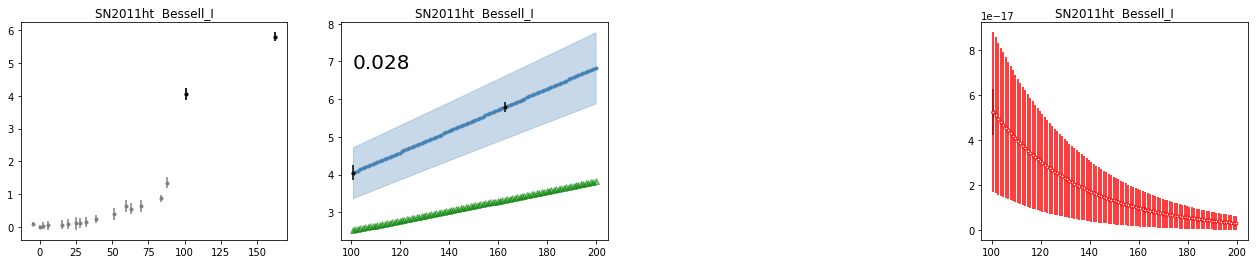

Bessell_R
Bessell_R 180.79999999999563
1.8859444249631805 0.02644399643905898
0.45081515709464454 0.0028467257809169375


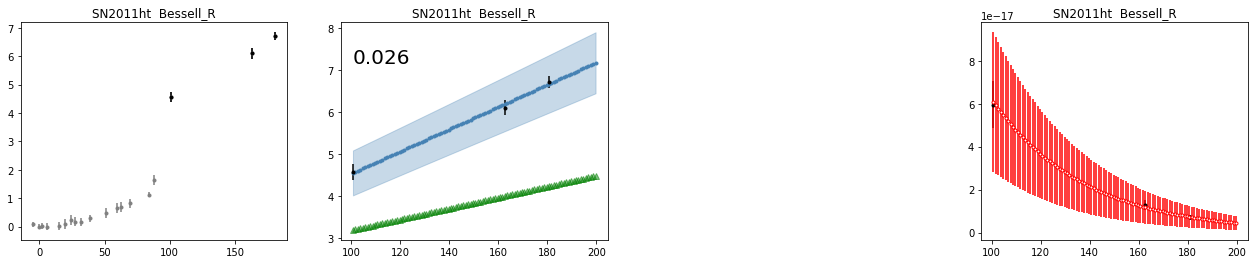

Bessell_V
Bessell_V 147.6999999999971
3.4353577862968905 0.02117037728706722
0.5413383486084978 0.004745004733640641


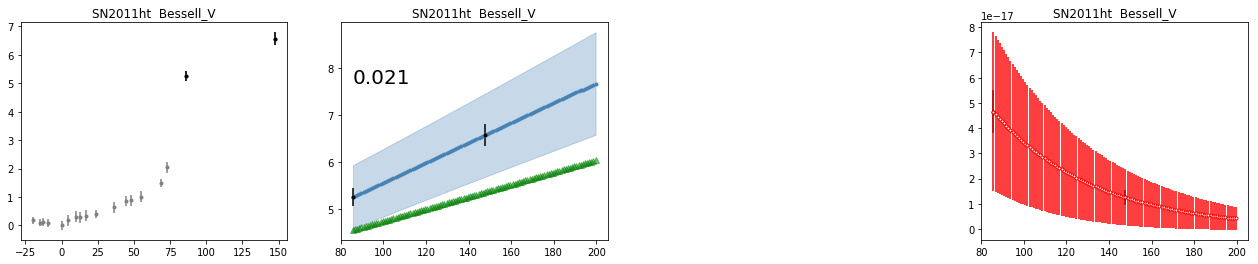

In [23]:
for sn in ['SN2011ht']:
    if sn in list(dict_phase_tail.keys()):
        prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname=sn, verbose=True)
        prova2.load()
        prova2.get_availfilter()
        prova2.clip_photometry()
        df = prova2.create_extended_LC()
        df.to_csv(prova2.sn_rawphot_file.replace('/Final_LC_NOMW_dust_corr/','/Final_LC_NOMW_sudopts/'), na_rep='nan',
              index=False, sep='\t', header=['#MJD','band','Flux','Flux_err','FilterSet','Source'])
    else:
        file = DATALC_PATH+sn+'.dat'
        shutil.copy2(file, file.replace('/Final_LC_NOMW_dust_corr/','/Final_LC_NOMW_sudopts/'))
        print ('copied', file.replace('/Final_LC_NOMW_dust_corr/','/Final_LC_NOMW_sudopts/'))


In [13]:
prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname='SN2011ei', verbose=True)
prova2.load()
prova2.get_availfilter()
prova2.clip_photometry()
prova2.get_availfilter()

Looking for Photometry for SN2011ei in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW_dust_corr//SN2011ei.dat
Got it!
Photometry loaded
Bessell_B Before clipping 9, after 9
Bessell_I Before clipping 10, after 10
Bessell_R Before clipping 11, after 11
Bessell_V Before clipping 12, after 12
swift_B Before clipping 21, after 21
swift_U Before clipping 14, after 14
swift_UVW1 Before clipping 9, after 9
swift_UVW2 Before clipping 5, after 5
swift_V Before clipping 21, after 21


array(['Bessell_B', 'Bessell_I', 'Bessell_R', 'Bessell_V', 'swift_B',
       'swift_U', 'swift_UVW1', 'swift_UVW2', 'swift_V'], dtype='<U10')

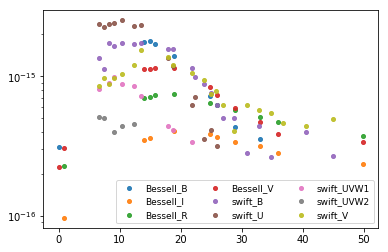

In [14]:
for ff in np.unique(prova2.clipped_phot['filter'])[:]:
    msk=prova2.clipped_phot['filter']==ff
    plt.plot(prova2.clipped_phot['MJD'][msk]-min(prova2.clipped_phot['MJD']),
             prova2.clipped_phot['flux'][msk], 'o', ms=4, alpha=0.9, label=ff)
plt.legend(ncol=3, fontsize=9)
plt.yscale('log')


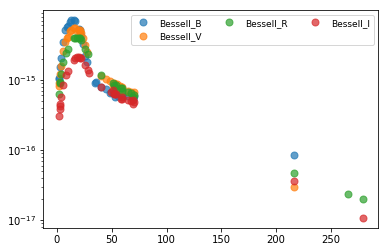

In [16]:
for ff in ['Bessell_B', 'Bessell_V', 'Bessell_R','Bessell_I']:#np.unique(prova2.clipped_phot['filter'])[4:]:
    msk=prova2.clipped_phot['filter']==ff
    plt.plot(prova2.clipped_phot['MJD'][msk]-min(prova2.clipped_phot['MJD']),
             prova2.clipped_phot['flux'][msk], 'o', ms=7, alpha=0.7, label=ff)
plt.legend(ncol=3, fontsize=9)
plt.yscale('log')


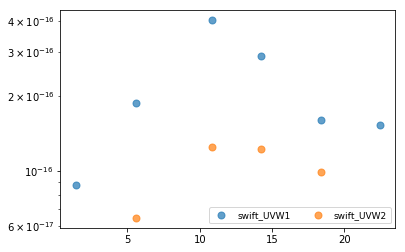

In [17]:
for ff in ['swift_UVW1', 'swift_UVW2']:
    msk=prova2.clipped_phot['filter']==ff
    plt.plot(prova2.clipped_phot['MJD'][msk]-min(prova2.clipped_phot['MJD']),
             prova2.clipped_phot['flux'][msk], 'o', ms=7, alpha=0.7, label=ff)
plt.legend(ncol=3, fontsize=9)
plt.yscale('log')


Bessell_U
0.6170036004277629 0.03916854299003573
0.43884881624958305 0.005743042658952603


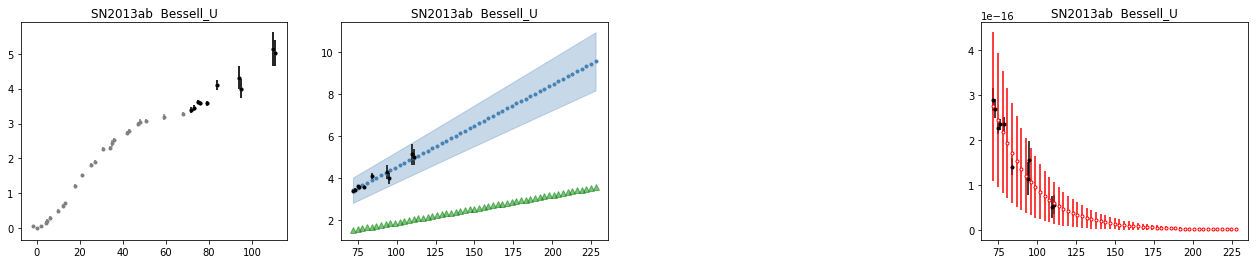

In [129]:
df = prova2.create_extended_LC()
df.to_csv(prova2.sn_rawphot_file.replace('/Final_LC_NOMW/','/Final_LC_NOMW_sudopts/'),na_rep='nan',
      index=False, sep='\t', header=['#MJD','band','Flux','Flux_err','FilterSet','Source'])

Looking for Photometry for SN2011dh in/Users/mariavincenzi/PhD/pycoco_2/prepare_photometry/Final_LC_NOMW//SN2011dh.dat
Got it!
Photometry loaded
Bessell_B Before clipping 12, after 12
Bessell_I Before clipping 12, after 12
Bessell_R Before clipping 12, after 12
Bessell_U Before clipping 12, after 12
Bessell_V Before clipping 12, after 12
swift_B Before clipping 39, after 39
swift_U Before clipping 40, after 39
swift_UVW1 Before clipping 38, after 38
swift_UVW2 Before clipping 39, after 38
swift_V Before clipping 39, after 39


<ErrorbarContainer object of 3 artists>

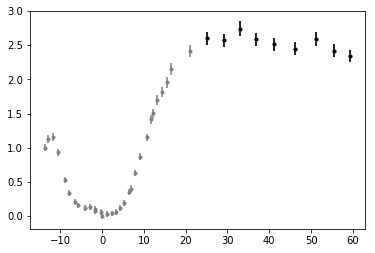

In [94]:
prova2 = SNPhotometryClass(main_path=DATAMAIN_PATH, lc_path= DATALC_PATH,snname='SN2011dh', verbose=True)
prova2.load()
prova2.get_availfilter()
prova2.clip_photometry()

LC_filt_extended = prova2.get_singlefilter("swift_U", extended_clipped=True)

mjd_unsorted = LC_filt_extended['MJD']
mjd = np.sort(mjd_unsorted)
orig_flux = LC_filt_extended['flux'][np.argsort(mjd_unsorted)]
orig_flux_err = LC_filt_extended['flux_err'][np.argsort(mjd_unsorted)]

# prepare data to feed the GP
## norm time
offset_time = mjd[np.argmax(orig_flux)]
t = mjd - offset_time
## norm flux
max_fl = max(orig_flux)
logf = -np.log(orig_flux/max_fl)
logferr = orig_flux_err/orig_flux

### linear regression to guess the slope

mask_lenght = 25#dict_Phase_Decay[prova2.snname]
mask_tail = t>mask_lenght
t_lr = t[mask_tail]
logf_lr = logf[mask_tail]
logferr_lr = logferr[mask_tail]
w_lr = 1./logferr_lr**2

plt.errorbar(t, logf, yerr=logferr, marker='.', 
             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')



2.8382849975375946 -0.007383736570896134
0.11907046451462751 0.002692232309784682


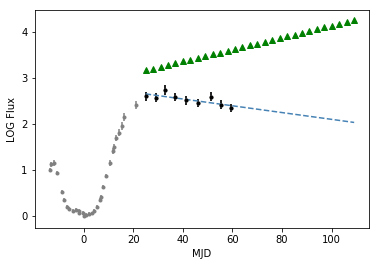

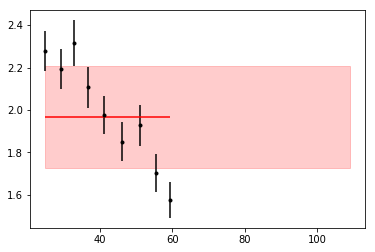

NameError: name 'err_prop_func' is not defined

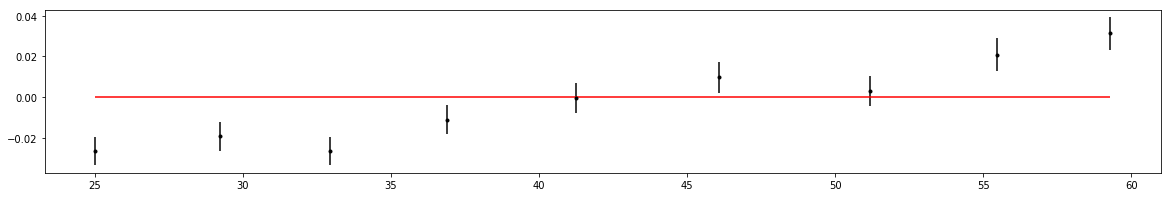

In [95]:
new_t = np.arange(min(t_lr), max(t_lr)+50 ,3)

plt.errorbar(t, logf, yerr=logferr,marker='.', 
             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

qq, mm, sigma_qq, sigma_mm = lin_regr_weigthed(t_lr, logf_lr,w_lr)

plt.plot(new_t, mm*(new_t)+qq, '--', color="#4682b4", alpha=1)
plt.plot(new_t, mm_cob56*(new_t)+qq, '^', color="g", alpha=1)

plt.xlabel('MJD')
plt.ylabel('LOG Flux')
plt.show()

plt.errorbar(t_lr, logf_lr-mm_cob56*t_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')


if mm<mm_cob56:
    avg, inv_err = np.average(logf_lr-mm_cob56*t_lr, weights=1/(logferr_lr**2), returned=True)
    #std_qq = np.sqrt(1./inv_err)
    sigma_qq = np.std(logf_lr-mm_cob56*t_lr)
    plt.hlines(avg, min(t_lr), max(t_lr), 'r')
    plt.fill_between(new_t,  avg-sigma_qq,
                  avg+sigma_qq, color="r", alpha=0.2)
    plt.show()
    mm=mm_cob56
    qq= avg


fsub_lr = np.exp(-(logf_lr)) - np.exp(-(t_lr*mm+qq))
ferrsub_lr = np.copy(orig_flux_err[mask_tail])/max(orig_flux)

fig = plt.figure(1, figsize=(20,3))
plt.errorbar(t_lr, fsub_lr, yerr=ferrsub_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
plt.hlines(0, min(t_lr), max(t_lr), 'r')

plt.fill_between(new_t,  - err_prop_func(new_t),
                  + err_prop_func(new_t), color="r", alpha=0.2)
plt.xlabel('MJD')
plt.ylabel('LOG Flux - LINEAR REGRESSION')

plt.xlim(min(t_lr)-1, max(t_lr)+1)
plt.show()

plt.errorbar(t_lr, logf_lr, yerr=logferr_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
plt.xlabel('MJD')
plt.ylabel('LOG Flux')


plt.plot(new_t, mm*(new_t)+qq, '.', color="#4682b4", alpha=1)
err_prop_func = lambda x: ( (x*sigma_mm)**2 + sigma_qq**2 )**0.5

plt.fill_between(new_t, mm*(new_t)+qq - err_prop_func(new_t),
                  mm*(new_t)+qq + err_prop_func(new_t), color="#4682b4", alpha=0.3)
plt.plot(new_t, mm_cob56*(new_t)+qq, '^', color="g", alpha=1)

plt.show()
#

fit = max_fl * np.exp(-(new_t*mm+qq))
fit_err = np.abs(fit * err_prop_func(new_t))

#plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
#             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
             mfc='white', mec='r', color='r', linestyle='None')
plt.xlabel('MJD')
plt.ylabel('Flux')


plt.show()

plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

plt.errorbar(new_t, fit, yerr=fit_err, marker='.', 
             mfc='white', mec='r', color='r', linestyle='None')
plt.xlabel('MJD')
plt.ylabel('Flux')


plt.show()



In [ ]:
gp_sub = george.GP(np.var(fsub_lr)*Matern32Kernel(20.))
gp_sub.compute(t_lr, ferrsub_lr)

def ll(p):
    gp_sub.set_parameter_vector(p)
    return -gp_sub.lnlikelihood(fsub_lr, quiet=False)#
def grad_ll(p):
    gp_sub.set_parameter_vector(p)
    return -gp_sub.grad_lnlikelihood(fsub_lr, quiet=False)
        
p0=gp_sub.get_parameter_vector()
results = opt.minimize(ll, p0, jac=grad_ll)

mu,cov = gp_sub.predict(fsub_lr, new_t, return_cov=True)
std = np.sqrt(np.diag(cov))

plt.errorbar(t_lr, fsub_lr, yerr=ferrsub_lr,marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

plt.plot(new_t, mu, color="#4682b4", alpha=1)
plt.fill_between(new_t, mu-std, mu+std, color="#4682b4", alpha=0.3)


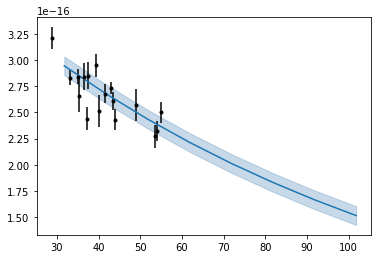

<ErrorbarContainer object of 3 artists>

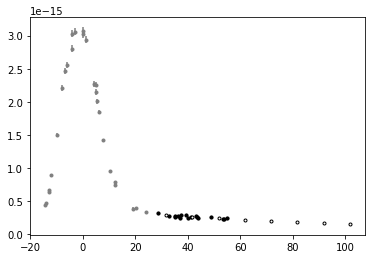

In [818]:
plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')

fit = max_fl*(mu + np.exp(-(new_t*mm+qq)))
fit_err = std*max_fl
plt.plot(new_t, fit)
plt.fill_between(new_t, fit-fit_err, fit+fit_err, color="#4682b4", alpha=0.3)
plt.show()

plt.errorbar(t, orig_flux, yerr=orig_flux_err, marker='.', 
             mfc='grey', mec='grey', color='grey', linestyle='None')

plt.errorbar(t_lr, orig_flux[mask_tail], yerr=orig_flux_err[mask_tail], marker='.', 
             mfc='k', mec='k', color='k', linestyle='None')
plt.errorbar(new_t, fit, yerr=fit_err,marker='.', 
             mfc='white', mec='k', color='k', linestyle='None')

# MJD, band, Flux, Flux_err, FilterSet Source
#extra_pts = 

In [811]:
lc_file = pd.DataFrame(np.genfromtxt(prova2.sn_rawphot_file,names=True, dtype=None,encoding="utf-8"))
extr_pts_pd = pd.DataFrame().reindex_like(lc_file)[:0]
extr_pts_pd['MJD'] = new_t+offset_time
extr_pts_pd['band'] = np.full(len(new_t), fill_value=ff)
extr_pts_pd['Flux'] = fit
extr_pts_pd['Flux_err'] = fit_err
extr_pts_pd['FilterSet'] = np.full(len(new_t), fill_value='SUDO_PTS')
extr_pts_pd['Source'] = np.full(len(new_t), fill_value='SUDO_PTS')

In [773]:
extr_pts_pd['MJD'] = new_t+offset_time
extr_pts_pd['band'] = np.full(len(new_t), fill_value=ff)
extr_pts_pd['Flux'] = fit
extr_pts_pd['Flux_err'] = fit_err
extr_pts_pd['FilterSet'] = np.full(len(new_t), fill_value='SUDO_PTS')
extr_pts_pd['Source'] = np.full(len(new_t), fill_value='SUDO_PTS')

(20, 9)

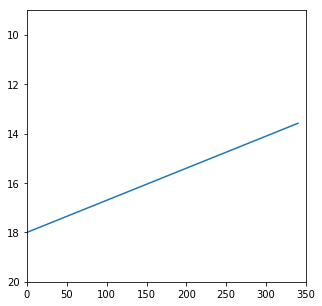

In [17]:

fig=plt.figure(figsize=(5,5))
tt=np.arange(0,350,10)
plt.plot(tt, -tt*mm_cob56+18)
plt.xlim(0,350)
plt.ylim(20,9)